## The learning algorithm

This reinforcement learning task was solved using Deep Deterministic Policy Gradient, an algorithm created by OpenAI. DDPG is closely related to Q-learning but adapted for use in continuous spaces. The algorithm utilises innovations from Q-learning such as fixed target and experience replay. The algorithm falls under an umbrella called the Actor-Critic method and consists of 4 networks: actor, critic, target-actor and target-critic. 

The algorithm uses the current actor-network to choose an action a based on input state s, and the environment returns reward r and next_state s’. In the replay buffer, this is stored as an experience tuple, <s,a,r,s’>. The replay buffer is used to break correlations between consecutive experience tuples. The max size is 750000, and once it is full, the oldest experiences are discarded. Once BATCH_SIZE experiences are in the buffer, the agent begins learning.

The current actor and critic networks are updated as follows:
1) A minibatch of experience tuples is sampled from the replay buffer randomly. 
2) Action a’ is then chosen by the target-actor and evaluated by the target-critic. 
3) This value is then discounted by gamma, added to reward r to from y.
4) The loss is then calculated by the MSE of y, and the expected value of action a calculated by the current critic.
5) This loss is used to update the current critic through backpropagation.
6) We then update the actor-network by taking the derivative of the critic network with respect to the policy parameters, using the mean of the gradients in the mini-batch.

The target networks are just delayed copies of the actor and critic networks, which improves stability as the agent is chasing a much slower-moving target. Every episode, these target networks are updated by a small amount, tau, to match the current actor and critic closely. This project performs a hard update (current weights completely transferred to target weights) every HARD_FREQ, reducing training time without causing any stability issues.

In this implementation, agents share their experience by soft copying eachothers local actor networks every 100 episodes. Each agent has its own replay buffer, and set of neural networks. Although, hyperparameters are the same for both. Each timestep, both agents undergo the same update process.


## Hyperparameter Choice

BUFFER_SIZE = int(0.75e6) #smaller than usual due to having 2    
BATCH_SIZE = 256        # chosen to fit in GPU memory   
GAMMA = 0.95           # discount factor   
TAU = 0.5e-3              # low due to addition of hard updates   
LR_ACTOR = 1e-4         # learning rate of the actor    
LR_CRITIC = 1e-4        # learning rate of the critic   
WEIGHT_DECAY = 0        # L2 weight decay   
EPSILON_DEC =0.995   #noise reduction   
TRAIN_FREQ=10     #how often train agent   
HARD_FREQ=200    #how often to perform the hard update   
TRAIN_N=5      #how many times train agent   
sharing=0.1    #agents share their ideas.  
  
fc_1 = 350 #smaller to combat multi agent instability   
fc_2 = 250 #decrease as action vector much smaller than state vector        

## Enviroment Setup

In [1]:
!pip -q install ./python
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Imports

In [2]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from Agent import Agent

env_info = env.reset(train_mode=True)[brain_name]

agent0 = Agent(state_size=24, action_size= 2, random_seed=2)
agent1 = Agent(state_size=24, action_size= 2, random_seed=2)

## Training Loop

In [3]:
def ddpg(n_episodes=2500, max_t=1000, print_every=100, sharing=0.1):
    scores_deque0 = deque(maxlen=print_every)
    scores_deque1 = deque(maxlen=print_every)
    scores0 = []
    scores1 = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state0 = env_info.vector_observations[0] 
        state1 = env_info.vector_observations[1] 
        agent0.reset()
        agent1.reset()
        score0 = 0
        score1 = 0
        for t in range(max_t):
            action0 = agent0.act(state0)
            action1 = agent1.act(state1)
            env_info = env.step(np.array([action0,action1]))[brain_name]
            next_state0 = env_info.vector_observations[0]  
            next_state1 = env_info.vector_observations[1] 
            reward0 = env_info.rewards[0]     
            reward1 = env_info.rewards[1] 
            done0 = env_info.local_done[0]   
            done1 = env_info.local_done[1]
            agent0.step(state0, action0, reward0, next_state0, done0)
            agent1.step(state1, action1, reward1, next_state1, done1)
            state0 = next_state0
            state1 = next_state1
            score0 += reward0
            score1 += reward1
             
            if done0 or done1:
                break 
        scores_deque0.append(score0)
        scores_deque1.append(score1)
        scores0.append(score0)
        scores1.append(score1)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tScore: {:.2f}\tAverage Score over 100 episodes: {:.2f}'.format(i_episode, max(score0,score1), max(np.mean(scores_deque0),np.mean(scores_deque1)), end="\n"))
            
            #agents share their experience
            for actor0_param, actor1_param in zip(agent0.actor_local.parameters(), 
agent1.actor_local.parameters()):
                actor0_param.data.copy_(sharing*actor1_param.data + 
(1.0-sharing)*actor0_param.data)
                actor1_param.data.copy_(sharing*actor0_param.data + 
(1.0-sharing)*actor1_param.data)
                  
        if max(np.mean(scores_deque0), np.mean(scores_deque1)) >= 0.5:
            print('\rEpisode {}\tScore: {:.2f}\tAverage Score over 100 episodes: {:.2f}'.format(i_episode, max(score0,score1), max(np.mean(scores_deque0),np.mean(scores_deque1)), end="\n"))
            print('\nEnvironment solved in {:d} episodes!\tEnded in episode: {:d}'.format(i_episode-100,i_episode ))
            torch.save(agent0.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent0.critic_local.state_dict(), 'checkpoint_critic.pth')
            break    
            
    return scores0
scores = ddpg()

Episode 100	Score: 0.00	Average Score over 100 episodes: -0.00
Episode 200	Score: 0.00	Average Score over 100 episodes: 0.00
Episode 300	Score: 0.00	Average Score over 100 episodes: 0.00
Episode 400	Score: 0.00	Average Score over 100 episodes: 0.00
Episode 500	Score: 0.00	Average Score over 100 episodes: 0.01
Episode 600	Score: 0.00	Average Score over 100 episodes: 0.03
Episode 700	Score: 0.00	Average Score over 100 episodes: 0.03
Episode 800	Score: 0.10	Average Score over 100 episodes: 0.05
Episode 900	Score: 0.10	Average Score over 100 episodes: 0.06
Episode 1000	Score: 0.10	Average Score over 100 episodes: 0.07
Episode 1100	Score: 0.10	Average Score over 100 episodes: 0.06
Episode 1200	Score: 0.09	Average Score over 100 episodes: 0.08
Episode 1300	Score: 0.10	Average Score over 100 episodes: 0.09
Episode 1400	Score: 0.20	Average Score over 100 episodes: 0.14
Episode 1500	Score: 0.20	Average Score over 100 episodes: 0.28
Episode 1550	Score: 1.10	Average Score over 100 episodes: 0.50


### Enviroment was solved in 1000 episodes. Below is a plot of scores per episode

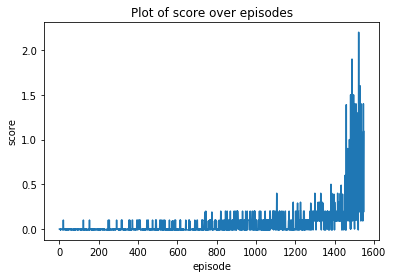

In [4]:
plt.plot(scores)
plt.xlabel('episode')
plt.ylabel('score')
plt.title('Plot of score over episodes')
plt.show()

## Future Imporvement

Hyperparamters could use a lot more tuning. In addition it may be worthwile adding memory collaboration (agents share experiences from their replay buffers). In addition, it is likely that placing prior- ity on important/rare experience tuple will lead to faster convergence. Also lot more investigation can be done on the exploration vs exploitation front, as adding noise is far more abstract than the epsilon greedy policy used in regular Q-learning. In addition, the Ornstein-Uhlenbeck process may be an overly complex way to add noise, and simpler methods like normally distributed may also work.